# Linear Interpolation

In [1]:
# add project source to path for use in the notebook
import os
import sys
import copy
import itertools

project_dir = '\\'.join(list(os.getcwd().split('\\')[:-1]))

sys.path.append(project_dir)

We begin by importing some required libraries, including the `loss_landscapes.lines` module.

In [12]:
# libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [10, 5]

# code from this library - import the lines module
import loss_landscapes.lines

## Linear Interpolation without Filter Normalization
The first use case we demonstrate is producing a linear interpolation plot (without filter normalization). We begin by defining a neural network model using `pytorch`. The model is going to be a convnet, which we will train (only a little) on MNIST before producing a linear interpolation plot of the loss landscape.

In [3]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 10, kernel_size=(5,5), stride=(1,1), padding=(2, 2))
        self.maxpool_1 = torch.nn.MaxPool2d(2,2)
        self.conv_2 = torch.nn.Conv2d(10, 20, kernel_size=(5,5), stride=(2,2))
        self.maxpool_2 = torch.nn.MaxPool2d(2, 2)
        self.linear_1 = torch.nn.Linear(20 * 2 * 2, 40)
        self.linear_2 = torch.nn.Linear(40, 10)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.maxpool_1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        x = F.relu(x)
        x = x.view(-1, 20 * 2 * 2)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = self.softmax(x)
        return x

Then we write a standard training loop, with the exception of holding on to the model's initial `state_dict` and its final `state_dict`.

In [4]:
# download MNIST
mnist_train = datasets.MNIST(root='../data/', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)

# define model
model = Network()
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

# save initial state_dict
start_params = copy.deepcopy(model.state_dict())

# train model
for epoch in tqdm(range(2)):
    for batch in trainloader:
        x, y = batch
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        
end_params = copy.deepcopy(model.state_dict())

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:55<00:00, 27.66s/it]


We also need to define an evaluation function, which the `loss_landscapes` library will use to compute the loss for a particular set of parameters. Note that the function below does not use the entire dataset to compute the loss, but rather only uses a random sample of 128 images split into 4 batches of 32. This is just to allow the notebook to terminate sooner. Note that this makes the linear interpolation plot essentially meaningless - if you wish to try this "for real", uncomment the commented out code in the last cell.

In [7]:
def evaluate(model):
    mnist_train = datasets.MNIST(root='../data/', train=True, download=True, transform=transforms.ToTensor())
    trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
    
    criterion = torch.nn.CrossEntropyLoss()
    
    average_loss = 0 
    for batch in itertools.islice(trainloader, 4):
        x, y = batch
        
        pred = model(x)
        loss = criterion(pred, y)
        average_loss += loss
    
    average_loss /= 4
    return average_loss

As mentioned above, below is a more meaningful, but more computationally intensive evaluation function. If you wish to use this one to generate the linear interpolation, edit the last cell.

In [ ]:
def evaluate_for_real(model):
    mnist_train = datasets.MNIST(root='../data/', train=True, download=True, transform=transforms.ToTensor())
    trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
    
    criterion = torch.nn.CrossEntropyLoss()
    
    average_loss = 0 
    for batch in trainloader:
        x, y = batch
        
        pred = model(x)
        loss = criterion(pred, y)
        average_loss += loss
    
    average_loss /= 1875
    return average_loss

Finally, we use this to compute a linear interpolation, which we then visualize as a line plot.

c:\users\marce\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


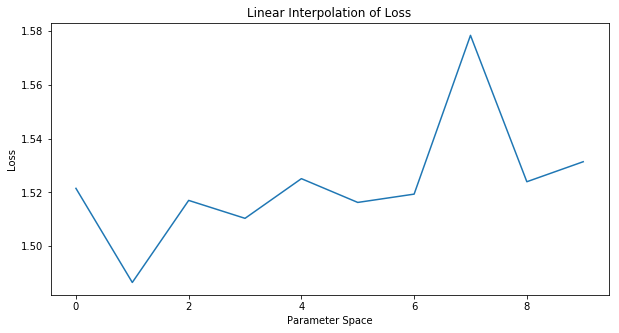

In [13]:
# if you want a proper evaluation, uncomment this line and comment out the one below
# loss_data = loss_landscapes.lines.linear_interpolation(model, start_params, end_params, evaluate_for_real, 100)

loss_data = loss_landscapes.lines.linear_interpolation(model, start_params, end_params, evaluate, 10)
plt.plot(loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Parameter Space')
plt.ylabel('Loss')
plt.show()